# Neural Networks (2025-01):  Homework 2
(Due: 2025.5.27 11:59 pm)

**Formatting: please include both a .ipynb and .pdf file in your homework submission, named studentID_homework2.ipynb and studentID_homework2.pdf.  Please don't change the filename.**   

In this homework, we will train and test convolutional neural network for image classification.

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data




## Obtain and Organize the Data Sets

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.


Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this homework, we will use the CIFAR10 dataset. The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

Here are the classes in the dataset, as well as 10 random images from each:

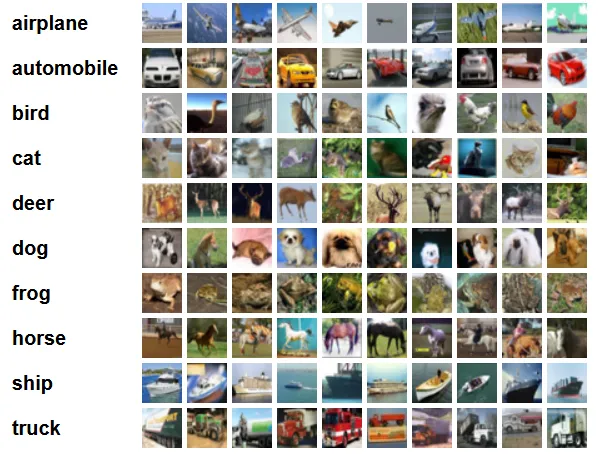




In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

#device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## Training hyperparameters

The following hyper-parameters can be tuned.
*   Hyper parameters for training
      *   epoch (`num_epochs`)= one forward and backward pass of ALL training samples
      *   batch size (`batch_size`)= number of training samples used in one forward/backward pass
      *   number of iterations = number of passes, each pass (forward+backward) using [batch_size] number of samples (e.g., 100 samples, batch_size=20 -> 100/20=5 iterations for 1 epoch)



In [15]:
#hyper paramter for training
num_epochs = 1
batch_size = 32
learning_rate = 0.001

## Read the Data Set
Next, we can create the Dataset instance to read the organized data set containing the original image files, where each data instance includes the image and label. DataLoader `train_loader` can do the batch computation for us.

shape: (50000, 3, 32, 32)
min: (np.float32(-1.0), np.float32(-1.0), np.float32(-1.0))
max: (np.float32(1.0), np.float32(1.0), np.float32(1.0))
mean: (np.float32(-0.017200625), np.float32(-0.035683163), np.float32(-0.10693816))
std: (np.float32(0.121056795), np.float32(0.122249946), np.float32(0.13529024))
shape: (10000, 3, 32, 32)
min: (np.float32(-1.0), np.float32(-1.0), np.float32(-1.0))
max: (np.float32(1.0), np.float32(1.0), np.float32(1.0))
mean: (np.float32(-0.011571422), np.float32(-0.029737204), np.float32(-0.0991818))
std: (np.float32(0.12095944), np.float32(0.12247972), np.float32(0.13516872))
tensor([[[ 0.2392,  0.2471,  0.2941,  ...,  0.0745, -0.0118, -0.0902],
         [ 0.1922,  0.1843,  0.2471,  ...,  0.0667, -0.0196, -0.0667],
         [ 0.1843,  0.1843,  0.2392,  ...,  0.0902,  0.0196, -0.0588],
         ...,
         [-0.4667, -0.6706, -0.7569,  ..., -0.7020, -0.8980, -0.6863],
         [-0.5216, -0.6157, -0.7255,  ..., -0.7961, -0.7725, -0.8431],
         [-0.5765, -

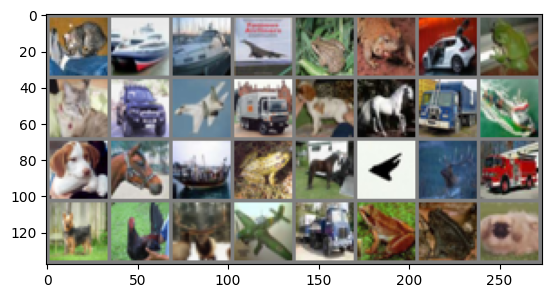

In [11]:
#dataset has PILImage images
#We transform them to Tensors of normalized range [-1, 1]
#to have the same distributions of RGB channels with the zero mean

#Compose multiple Transforms : applying multiple transforms each other


transform = transforms.Compose(
    [transforms.ToTensor(), # normalize 0 to 1
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # substract mean and divide the std to have min -1 to max 1

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def print_stats(dataset):
    imgs = np.array([img.numpy() for img, _ in dataset])
    print(f'shape: {imgs.shape}')

    min_r = np.min(imgs, axis=(2, 3))[:, 0].min()
    min_g = np.min(imgs, axis=(2, 3))[:, 1].min()
    min_b = np.min(imgs, axis=(2, 3))[:, 2].min()

    max_r = np.max(imgs, axis=(2, 3))[:, 0].max()
    max_g = np.max(imgs, axis=(2, 3))[:, 1].max()
    max_b = np.max(imgs, axis=(2, 3))[:, 2].max()

    mean_r = np.mean(imgs, axis=(2, 3))[:, 0].mean()
    mean_g = np.mean(imgs, axis=(2, 3))[:, 1].mean()
    mean_b = np.mean(imgs, axis=(2, 3))[:, 2].mean()

    std_r = np.std(imgs, axis=(2, 3))[:, 0].std()
    std_g = np.std(imgs, axis=(2, 3))[:, 1].std()
    std_b = np.std(imgs, axis=(2, 3))[:, 2].std()

    print(f'min: {min_r, min_g, min_b}')
    print(f'max: {max_r, max_g, max_b}')
    print(f'mean: {mean_r, mean_g, mean_b}')
    print(f'std: {std_r, std_g, std_b}')

print_stats(train_dataset)
print('==='*10)
print_stats(test_dataset)


## get first sample and unpack
first_data = test_dataset[0]
features, labels = first_data
print(features, labels)

# convert to an iterator and look at few samples

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
test_examples = iter(test_loader)
example_test_data, example_test_labels = next(test_examples)

# show images
imshow(torchvision.utils.make_grid(example_test_data))
# print labels
print(' '.join('%5s' % classes[example_test_labels[j]] for j in range(4)))



## Define the Model
Here, we build the convolutional network as follows:

- Conv1 : 6 channels with 5x5 kernel sizes (no zero padding)
- Pooling
- Conv2 : 16 channels with 5x5 kernel sizes (no zero padding)
- Pooling

- and two FC layers

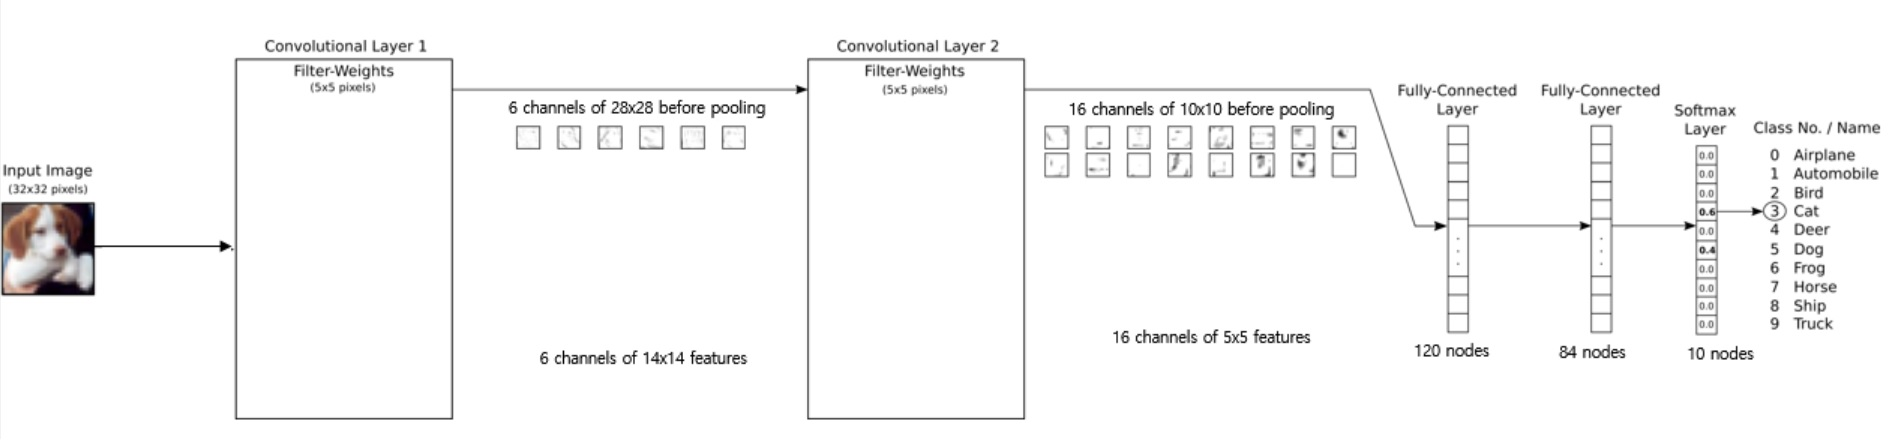

In [4]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    #https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
    self.conv1 = nn.Conv2d(3, 6, 5) # need to specify sizes (input channel, output chanel, and kernel size, etc.)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6,16,5)
    self.fc1=nn.Linear(16*5*5,120)
    self.fc2=nn.Linear(120,84)
    self.fc3=nn.Linear(84,10)

  def forward(self, x):
    # -> n, 3, 32, 32
    # (m - k + 2p)/S + 1
    x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14 (=(32-5)/1 + 1 -> pooling)
    x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5  (=(14-5)/1 + 1 -> pooling)
    x = x.view(-1, 16 * 5 * 5)            # -> n, 400
    x = F.relu(self.fc1(x))               # -> n, 120
    x = F.relu(self.fc2(x))               # -> n, 84
    x = self.fc3(x)                       # -> n, 10
    return x


## Train and Validate the Model
Now, we can train and validate the model. In the code below, we validate the model every 1000 iterations. After finishing training, we finally test the model using the validation set (Note we use the same set as validation and test set.)


In [16]:
model = ConvNet().to(device)

# loss and optimizer

criterion = nn.CrossEntropyLoss ( ) # apply softmax
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# training loop
n_total_steps = len (train_loader)

for epoch in range (num_epochs):
  for i, (images, labels) in enumerate (train_loader):
    # origin shape: [4, 3, 32, 32] = 4, 3, 1024
    # input_layer: 3 input channels, 6 output channels, 5 kernel size
    images = images.to(device)
    labels = labels.to(device)

    #forward
    outputs = model(images)
    loss = criterion (outputs, labels)
    n_samples= labels.shape[0]
    #the CrossEntropyLoss ( ) loss includes softmax function
    # (CrossEntropyLoss Function) https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
    # (softmax) https://deepai.org/machine-learning-glossary-and-terms/softmax-layer

    #backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1)% 1000 == 0:
      with torch.no_grad():
        n_correct = 0
        n_samples = 0

        # validate the model for all the validation data
        for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model (images)
          # max returns (value ,index)
          _, predicted = torch.max(outputs.data, 1)
          n_samples += labels.shape[0]
          n_correct += (predicted == labels).sum().item()

        valid_acc = 100.0 * n_correct / n_samples
      print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps},train loss={loss.item():.4f}, valid_acc={valid_acc} % ')
print('Finished traning')

#test

with torch.no_grad():
  n_correct = 0
  n_samples = 0

  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model (images)
    # max returns (value ,index)
    _, predicted = torch.max(outputs.data, 1)
    n_samples += labels.shape[0]
    n_correct += (predicted == labels).sum().item()


acc = 100.0 * n_correct / n_samples
print(f'Accuracy of the network on the test(validation) images after training: {acc} %')


epoch 1/2, step 1000/1563,train loss=1.4861, valid_acc=46.7 % 
epoch 2/2, step 1000/1563,train loss=1.2155, valid_acc=54.17 % 
Finished traning
Accuracy of the network on the test(validation) images after training: 54.78 %


## To Do: Build your own convolutional neural network

Build your own convolutional neural network to achieve test accuracy of at least **70%**.

* Hints to Improve Your Results

  * Change the training hyperparameters such as batch size `batch_size`, number of epochs `num_epochs` and learning rate `learning_rate`. (It will take a while to run.)
  * Try to add more convolution layers with different kernel sizes (e.g. 3x3 kernels).
  * (optional) Change to another network, such as ResNet-18 or Inception.

In your **studentID_homework2.pdf**, you should include your network architecture, training history, and test accuracy.

